In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

import os
from datetime import datetime
from pathlib import Path
import sys
import xlrd
import pycountry
from statistics import mean

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Add GDP Data

Here we follow the steps we did in Question 1 and create three new columns with the GDP data:

* `gdp_year_founded`: The GDP in the year startups founded.
* `gdp_growth_year_founded`: The GDP growth in the year startups founded.
* `avg_gdp_growth`: The average GDP growth between the first funding time and the last funding time.

The goal of this assignment is to create a model that can predict the amount of funding a start-up has received / will receive. These predictions will be done on the basis of several characteristics. In addition to the given dataset, we also looked for other data that could improve the quality of the model. We found a dataset that contains the GDP per country per year. We decided to add this data to the original dataset, because we think there might be a relationship between a country's GDP and the amount of funding that is available for start-ups within that country. 

In [2]:
df = pd.read_csv('group-project-data.csv')
df["year_founded"] = df.apply(lambda x: datetime.strptime(x["founded_at"], '%Y-%m-%d %H:%M:%S').date().year, axis=1)
df["year_first_funding"] = df.apply(lambda x: datetime.strptime(x["first_funding_at"], '%Y-%m-%d %H:%M:%S').date().year, axis=1)
df["year_last_funding"] = df.apply(lambda x: datetime.strptime(x["last_funding_at"], '%Y-%m-%d %H:%M:%S').date().year, axis=1)

gdp_data_df = pd.read_excel('gdp_data.xls')
gdp_data_df = gdp_data_df[gdp_data_df["IndicatorName"] == "Gross Domestic Product (GDP)"]
gdp_year_founding = []
for year, country in zip(df["year_founded"], df["country_code"]):
    country_in_pycountry = pycountry.countries.get(alpha_3=country)
    if country_in_pycountry:
        country_name = country_in_pycountry.name
        country_data = gdp_data_df[gdp_data_df["Country"] == country_name]
        gdp_year = country_data[year].values
        if len (gdp_year) > 0:
            gdp_year = gdp_year[0]
        else:
            gdp_year = np.nan
        gdp_year_founding.append(gdp_year)
    else:
        gdp_year_founding.append(np.nan)
df["gdp_year_founded"] = gdp_year_founding

gdp_growth_data_df = pd.read_excel('gdp_growth.xls')
gdp_growth_data_df = gdp_growth_data_df[gdp_growth_data_df["IndicatorName"] == "Gross Domestic Product (GDP)"]
gdp_growth_year_founding = []
for year, country in zip(df["year_founded"], df["country_code"]):
    country_in_pycountry = pycountry.countries.get(alpha_3=country)
    if country_in_pycountry:
        country_name = country_in_pycountry.name
        country_data = gdp_growth_data_df[gdp_growth_data_df["Country"] == country_name]
        gdp_year = country_data[year].values
        if len (gdp_year) > 0:
            gdp_year = gdp_year[0]
        else:
            gdp_year = np.nan
        gdp_growth_year_founding.append(gdp_year)
    else:
        gdp_growth_year_founding.append(np.nan)
df["gdp_growth_year_founded"] = gdp_growth_year_founding

avg_gdp_growth_first_last_funding = []
for year_first_funding, year_last_funding, country in zip(df["year_first_funding"], df["year_last_funding"], df["country_code"]):
    country_in_pycountry = pycountry.countries.get(alpha_3=country)
    if country_in_pycountry:
        country_name = country_in_pycountry.name
        country_data = gdp_growth_data_df[gdp_growth_data_df["Country"] == country_name]
        gdp_growth_list = []
        for year in range(year_first_funding, year_last_funding + 1):
            gdp_growth_current_year = country_data[year].values
            if len(gdp_growth_current_year) > 0:
                gdp_growth_list.append(gdp_growth_current_year)
        if len(gdp_growth_list) > 0:
            avg_gdp_growth = np.mean(gdp_growth_list)
            avg_gdp_growth_first_last_funding.append(avg_gdp_growth)
        else:
            avg_gdp_growth_first_last_funding.append(np.nan)
    else:
        avg_gdp_growth_first_last_funding.append(np.nan)
df["avg_gdp_growth"] = avg_gdp_growth_first_last_funding

df.drop(columns=['year_founded', 'year_first_funding', 'year_last_funding'], inplace=True)

# Data Exploration

### Overview
In this section, we looked at the datatype of each variable and we had a brief look at the data in general. In total, this dataset contains 17 columns. Eight of them contain null values, and five of them are numerical.

After scanning through the data in each column, we decided to take the following steps:

* The `name` and `homepage_url` columns only contain unique values (the start-ups do not have the same names or URLs). Therefore, they are not useful for building a machine learning model. To solve this issue, we decided to drop these columns.
* The columns `founded_at`, `first_funding_at`, and `last_funding_at` have 'object' as datatype, but they should be treated as continuous data and they should be converted into a numerical data type. Therefore, we transformed these columns.
* Last, we created a column `funding duration` which is calculated by the difference (in days) between `first_funding_at`, and `last_funding_at`. This column should benefit the model because we assume that a longer funding duration is likely to lead to a higher total funding amount.

In [3]:
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28729 entries, 0 to 28728
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     28729 non-null  object 
 1   homepage_url             27563 non-null  object 
 2   category_list            27898 non-null  object 
 3   market                   27896 non-null  object 
 4   funding_total_usd        28729 non-null  float64
 5   status                   28085 non-null  object 
 6   country_code             28729 non-null  object 
 7   state_code               20314 non-null  object 
 8   region                   28729 non-null  object 
 9   city                     28729 non-null  object 
 10  funding_rounds           28729 non-null  int64  
 11  founded_at               28729 non-null  object 
 12  first_funding_at         28729 non-null  object 
 13  last_funding_at          28729 non-null  object 
 14  gdp_year_founded      

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,gdp_year_founded,gdp_growth_year_founded,avg_gdp_growth
0,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01 00:00:00,2012-06-30 00:00:00,2012-06-30 00:00:00,1.619701e+13,2.249546,2.249546


In [4]:
# Drop "name" and "homepage_url" columns
df2 = df.drop(columns=['name', 'homepage_url'])

# Convert three time variables to "datetime" type
df2['founded_at'] = pd.to_datetime(df2['founded_at'], errors='coerce')
df2['first_funding_at'] = pd.to_datetime(df2['first_funding_at'], errors='coerce')
df2['last_funding_at'] = pd.to_datetime(df2['last_funding_at'], errors='coerce')

# Add a column for the funding duration
df2['funding_duration'] = (df2['last_funding_at'] - df2['first_funding_at']).apply(lambda x: x.days)

# Convert three time variables to numeric values
import datetime as dt
df2['founded_at'] = df2['founded_at'].map(dt.datetime.toordinal)
df2['first_funding_at'] = df2['first_funding_at'].map(dt.datetime.toordinal)
df2['last_funding_at'] = df2['last_funding_at'].map(dt.datetime.toordinal)

### Missing Data

Here we calculate the ratios of missing values in each column and drop the `state_code` column because it has significantly higher missing ratio (29%) compared to other columns. Furthermore, we fill the missing values in the three GDP columns with the mean values of each colummn.

In [5]:
# Calculate the ratios of missing values in each column
all_data_na = (df2.isnull().sum() / len(df2)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
print(missing_data)

# Drop "state_code" column that has extremely high missing ratio comparing to other columns
df3 = df2.drop(columns='state_code')

# Fill missing values in three GDP columns 
df3['gdp_growth_year_founded'].fillna(df3['gdp_growth_year_founded'].mean(), inplace=True)
df3['avg_gdp_growth'].fillna(df3['avg_gdp_growth'].mean(), inplace=True)
df3['gdp_year_founded'].fillna(df3['gdp_year_founded'].mean(), inplace=True)

                         Missing Ratio
state_code                   29.290960
market                        2.899509
category_list                 2.892548
status                        2.241637
gdp_growth_year_founded       1.155627
avg_gdp_growth                1.152146
gdp_year_founded              1.152146


### Examining Numerical Variables

Here we check the correlations between all numerical variables and the target variable based on the Pearson correlation coefficient. The heatmap indicates that `gdp_year_founded` has by far the lowest correlation with the target variable (-4.3e-06) and that `funding_rounds` and `funding duration` have a high correlation with the target variable.

Therefore, we decided to keep all numerical variables except for `gdp_year_founded`.

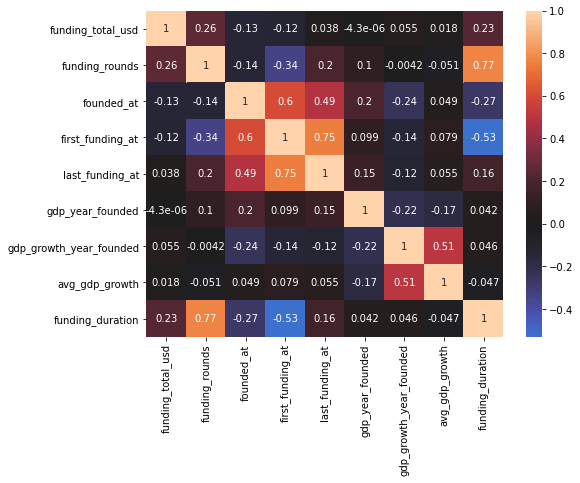

In [6]:
corrmat = df3.corr()
plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, center=0, annot=True);

df4 = df3.drop(columns='gdp_year_founded')

### Examining Categorical Variables

To prevent categorical variable from having too many levels/categories (which has a negative impact on the performance of the model), we decided to assign all categorical items with a lower frequency than 5% to the same category.

In [7]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def binding(col):
    df4.loc[(df4[col].map(df[col].value_counts()) / len(df3)) <= 0.05, col] = 'Other'

col_cat = ['category_list', 'market', 'status', 'country_code', 'region', 'city']
for col in col_cat:
    binding(col)

# Final Preparations

### Train-Test Split
In this section, we create a training and test set. We did this before dropping any observation (row) to ensure that the distribution of test data is close to the real situation.

In [8]:
from sklearn.model_selection import train_test_split

X = df4.drop(columns='funding_total_usd')
y = df4['funding_total_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### Missing Data in the Training Set

Here, we drop observations (rows) from the training set that contain missing values. First we calculated the ratio of rows with missing values in the training set. Because this was a relatively low ratio (lower than 5%), we decided it would be best to delete them.

In [9]:
train = pd.concat([X_train, y_train], axis=1)

# Ratio of rows with missing values
print('Ratio of rows with missing values:')
print(len(train[train.isna().any(axis=1)]) / len(train))

# Remove all rows with missing values
train2 = train[~train.isna().any(axis=1)]

Ratio of rows with missing values:
0.04825305660705739


### Outliers

Outliers can significantly affect the performance of the prediction model. Here we calculate the Z-score of each observation based on the target variable. It shows that around 0.8% of the values in the `funding_total` column are outliers. We decided to remove these from the training set to prevent distortion during the training process. 

In [10]:
# Remove outliers based the on Z-scores of target variable
from scipy.stats import zscore
print('Percentage of outliers:')
print(1 - len(train2[(zscore(train2['funding_total_usd']) <= 3) & (zscore(train2['funding_total_usd']) >= -3)]) / len(train2))
train3 = train2[(zscore(train2['funding_total_usd']) <= 3) & (zscore(train2['funding_total_usd']) >= -3)]

X_train = train3.drop(columns='funding_total_usd')
y_train = train3['funding_total_usd']

Percentage of outliers:
0.0075432019749474


### Get Dummies

Here we use One-Hot Encoding to transfer categorical data into numerical data for the modeling. For each variable, we dropped the first column to avoid multicollinearity. 

In [11]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Modelling

Here we try the following four algorithms to build the model that can predict the amount of funding start-ups receive. We chose these four algorithms because they are suitable for predicting a continuous target variable.

* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor
* GradientBoostingRegressor  

For each algorithm, we calculate the training and test scores with the default setting of each model. The training score is caculated with 5-fold cross-validation to reduce the bias and variance in the modelling process. The test score shows the R squared value between the predicted and expected values. These two scores enable us to check the generalizability of each model.

In [12]:
mdl = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor]

for i in mdl:
    model = i()
    name = type(model).__name__
    model.fit(X_train, y_train)
    
    train_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1).mean().round(4)
    test_score = model.score(X_test, y_test).round(4)
    
    print(f'<{name}>')
    print(f'training score: {train_score}')
    print(f'testing  score: {test_score}')
    print('')

<LinearRegression>
training score: 0.3011
testing  score: 0.1393

<DecisionTreeRegressor>
training score: -0.4172
testing  score: -0.0312

<RandomForestRegressor>
training score: 0.2525
testing  score: 0.1561

<GradientBoostingRegressor>
training score: 0.3317
testing  score: 0.1664



# Feature Importance

In this section, we looked at the feature importance for the `LinearRegression` model and the `GradientBoostingRegressor` model because the first one is the only linear model and the second has the best performance among the three tree models. This was different per model.

LinearRegression:
* This model is basically built on only three variables `last_funding_at`, `first_funding_at`, and `funding_duration`. The rest variables create almost no value to the model.

GradientBoostingRegressor:
* In contrast with the linear model, `funding_duration`, `funding_rounds`, and `founded_rounds` are the three most important variables for this model.

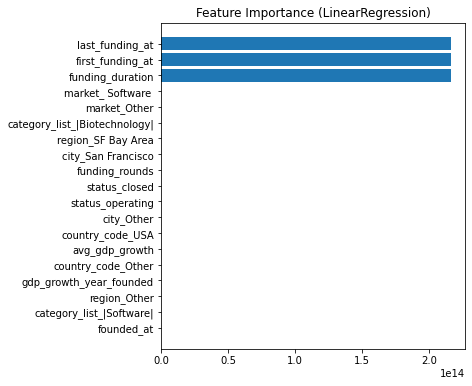

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

feature_importance = np.absolute(model.coef_)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (LinearRegression)')
plt.show()

bad_col_lr = X_train.columns[sorted_idx]

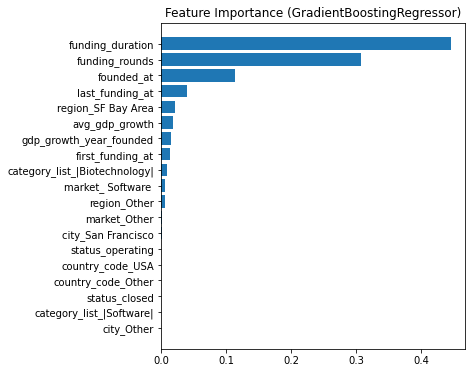

In [14]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (GradientBoostingRegressor)')
plt.show()

bad_col_gbr = X_train.columns[sorted_idx]

# Dropping less important features

Here we examined if the performance of the models could be improved by dropping less important features. We used the insights from the previous section to select the features.

We found out that dropping columns do not lead to a better performance in this case. Therefore, our final model is trained with all available columns.

### LinearRegression

In [15]:
col = bad_col_lr    
train_score_lr = []
test_score_lr = []

for i in range(len(col)):
    X_train2 = X_train.drop(columns=col[:i])
    X_test2 = X_test.drop(columns=col[:i])
    X_train2 = pd.get_dummies(X_train2, drop_first=True)
    X_test2 = pd.get_dummies(X_test2, drop_first=True)

    # Modeling
    model = LinearRegression()
    model.fit(X_train2, y_train)
    a = cross_val_score(model, X_train2, y_train, cv=5, n_jobs=-1).mean().round(4)
    b = model.score(X_test2, y_test).round(4)

    train_score_lr.append(a)
    test_score_lr.append(b)

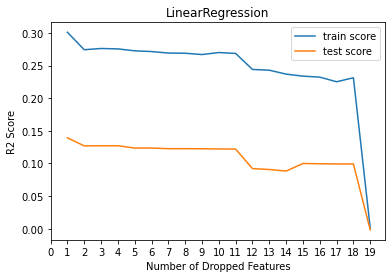

,feature,train_score,test_score
1,founded_at,0.3011,0.1393
2,category_list_|Software|,0.2743,0.1269
3,region_Other,0.2762,0.1271
4,gdp_growth_year_founded,0.2756,0.1271
5,country_code_Other,0.2726,0.1236
6,avg_gdp_growth,0.2715,0.1236
7,country_code_USA,0.2692,0.1226
8,city_Other,0.2689,0.1226
9,status_operating,0.2669,0.1225
10,status_closed,0.2700,0.1222


In [16]:
df_lr = pd.DataFrame(data={'feature': bad_col_lr, 'train_score': train_score_lr, 'test_score': test_score_lr},
                     index=np.arange(1,20))
xlabel = np.arange(1,len(df_lr)+1)
plt.plot(xlabel, df_lr['train_score'], label='train score')
plt.plot(xlabel, df_lr['test_score'], label='test score')
plt.xticks(np.arange(0, len(df_lr)+1, 1))
plt.xlabel('Number of Dropped Features')
plt.ylabel('R2 Score')
plt.title('LinearRegression')
plt.legend()
plt.show()

df_lr

### GradientBoostingRegressor

In [17]:
col = bad_col_gbr    
train_score_gbr = []
test_score_gbr = []

for i in range(len(col)):
    X_train2 = X_train.drop(columns=col[:i])
    X_test2 = X_test.drop(columns=col[:i])
    X_train2 = pd.get_dummies(X_train2, drop_first=True)
    X_test2 = pd.get_dummies(X_test2, drop_first=True)

    # Modeling
    model = GradientBoostingRegressor()
    model.fit(X_train2, y_train)
    a = cross_val_score(model, X_train2, y_train, cv=5, n_jobs=-1).mean().round(4)
    b = model.score(X_test2, y_test).round(4)

    train_score_gbr.append(a)
    test_score_gbr.append(b)

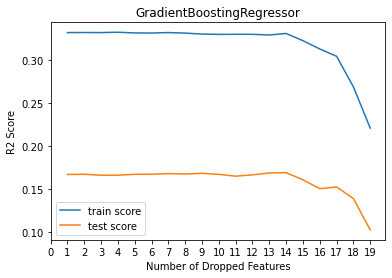

,feature,train_score,test_score
1,city_Other,0.3315,0.1668
2,category_list_|Software|,0.3316,0.1670
3,status_closed,0.3315,0.1659
4,country_code_Other,0.3319,0.1659
5,country_code_USA,0.3311,0.1670
6,status_operating,0.3310,0.1670
7,city_San Francisco,0.3315,0.1678
8,market_Other,0.3309,0.1673
9,region_Other,0.3298,0.1681
10,market_ Software,0.3294,0.1669


In [18]:
df_gbr = pd.DataFrame(data={'feature': bad_col_gbr, 'train_score': train_score_gbr, 'test_score': test_score_gbr},
                      index=np.arange(1,20))
xlabel = np.arange(1,len(df_lr)+1)
plt.plot(xlabel, df_gbr['train_score'], label='train score')
plt.plot(xlabel, df_gbr['test_score'], label='test score')
plt.xticks(np.arange(0, len(df_lr)+1, 1))
plt.xlabel('Number of Dropped Features')
plt.ylabel('R2 Score')
plt.title('GradientBoostingRegressor')
plt.legend()
plt.show()

df_gbr

# Hyperparameter tuning
Here we test different hyperparameters for the models in an attempt to improve their performance. We do this by using `Grid Search` so that we test multiple combinations at the same time. Besides, we do not look at the test scores during the Grid Search because you should never do this when choosing your hyperparamaters to avoid overfitting on the test set.

LinearRegression:
* For LinearRegression, we want to know whether the performance can be improved by adding `PolynomialFeatures` (which is essentially a variable transformation method) and by changing the settings of `fit_intercept` and `normalize`. 
* The results show that the 5-fold CV training scores are slightly better when adding the PolynomialFeatures with 3 degrees. 

GradientBoostingRegressor:
* For the GradientBoostingRegressor, we want to know whether the performance can be improved by changing the `learning_rate` and `n_estimators`. 
* The results show that the best parameters are {'learning_rate': 0.11, 'n_estimators': 100}. However, after changing to these parameters, the testing score is slightly lower than the score from the oringinal settings. It shows that there is an overfitting problem with the tuned parameters. Therefore, we conclude that the model already performed well with original setting and does not require further adjustments.

### LinearRegression

In [19]:
# Grid Search
param_grid = {'polynomialfeatures__degree': [1,2,3],
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}
grid_lr = GridSearchCV(make_pipeline(PolynomialFeatures(), LinearRegression()), param_grid, cv=5)
grid_lr.fit(X_train, y_train)
train_score = grid_lr.best_score_.round(4)

print('Best Hyperparameter (LinearRegression):')
print(grid_lr.best_params_)
print(f'training score: {train_score}')

Best Hyperparameter (LinearRegression):
{'linearregression__fit_intercept': False, 'linearregression__normalize': True, 'polynomialfeatures__degree': 3}
training score: 0.3102


In [20]:
# Compare to original parameters
model_1 = LinearRegression().fit(X_train, y_train)
test_score_1 = model_1.score(X_test, y_test).round(4)

model_2 = grid_lr.best_estimator_
test_score_2 = model_2.score(X_test, y_test).round(4)

print('<LinearRegression>')
print('testing score before fine tuning:')
print(test_score_1)
print('testing score after  fine tuning:')
print(test_score_2)

<LinearRegression>
testing score before fine tuning:
0.1393
testing score after  fine tuning:
0.149


### GradientBoostingRegressor

In [21]:
# Grid Search
param_grid = {'learning_rate':[0.09,0.1,0.11],
              'n_estimators':[100,200,300]}
grid_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, n_jobs=-1)
grid_gbr.fit(X_train, y_train)
train_score = grid_gbr.best_score_.round(4)

print('Best Hyperparameter (GradientBoostingRegressor):')
print(grid_gbr.best_params_)
print(f'training score: {train_score}')

Best Hyperparameter (GradientBoostingRegressor):
{'learning_rate': 0.11, 'n_estimators': 100}
training score: 0.3324


In [22]:
# Compare to original parameters
model_1 = GradientBoostingRegressor().fit(X_train, y_train)
test_score_1 = model_1.score(X_test, y_test).round(4)

model_2 = grid_gbr.best_estimator_
test_score_2 = model_2.score(X_test, y_test).round(4)

print('<GradientBoostingRegressor>')
print('testing score before fine tuning:')
print(test_score_1)
print('testing score after  fine tuning:')
print(test_score_2)

<GradientBoostingRegressor>
testing score before fine tuning:
0.1664
testing score after  fine tuning:
0.1652


# Conclusion

Our findings can be summarized as follows:

* The deletion of less important features did not lead to a better result so these features should be kept in the training set.

* The GradientBoostingRegressor model with the default hyperparameters ('learning_rate': 0.1, 'n_estimators': 100) is the best model to predict the funding amount of the start-ups, and our final test score is around 16.6%.